In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from IPython.display import clear_output

In [2]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]


In [3]:
icdata

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.37911273,3.31,0.48,203.024,16.760,218.374,106.712
1,54562.38662244,5.17,0.62,75.024,-13.371,349.100,76.646
2,54562.38789162,3.92,0.56,97.501,11.290,327.060,101.291
3,54562.39267689,5.57,1.13,305.857,-33.932,120.413,56.090
4,54562.40477593,5.80,1.11,143.516,-38.279,287.171,51.684
...,...,...,...,...,...,...,...
1134445,58307.96110988,5.14,0.20,221.246,-59.959,141.239,29.956
1134446,58307.96266638,2.94,1.23,191.547,4.415,171.627,94.312
1134447,58307.96355617,2.88,0.30,308.127,42.543,55.437,132.606
1134448,58307.96397167,2.98,0.21,332.199,44.720,31.489,134.811


In [4]:


#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/allpsr.txt", 'r')
lines = f.readlines()

content=[]
column=lines.pop(0).split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
mspdata = pd.DataFrame(content).dropna().drop_duplicates()#.drop(range(0,6)).dropna().drop([2,6,8,10,11,13,14], axis=1)
f.close()
line = []
lines = []

mspdata.columns = column
column = []
content=[]
mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
mspdata = mspdata.reset_index()
mspdata = mspdata.drop(["index", "#"], axis=1)

In [5]:
mspdata

,NAME,Gl,Gb,RAJD,DECJD,P0,F0,DIST
0,J1852-0000,33.066,-0.277,283.16736,-0.00708,1.92066632921,0.520652642675,5.776
1,J1843-0000,32.013,1.768,280.86652,-0.01153,0.880334321703,1.13593208324,3.336
2,J1849-0001,32.638,0.527,282.2568,-0.02151,0.038522586319205,25.958797047369,*
3,J1852-0002g,32.985,-0.177,283.04,-0.03,0.2451,4.079967,5.591
4,J1850-0002g,32.738,0.305,282.5,-0.03,0.89336,1.11937,5.732
...,...,...,...,...,...,...,...,...
3238,J0152+0948,146.812,-50.221,28.0989,9.8028,2.74664729014,0.364080238329,2.477
3239,J1908+0949g,43.562,0.797,287.03,9.82,0.00905,110.497238,6.001
3240,J0550+09,197.055,-8.774,87.6,9.85,1.745,0.573066,1.804
3241,B1914+09,44.556,-1.019,289.134769,9.857216,0.2702544395645,3.700216735057,1.904


In [6]:
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
icra = [float(i) for i in icdata['RA[deg]']]
icdec = [float(i) for i in icdata['Dec[deg]']]
icang = [float(i) for i in icdata['AngErr[deg]']]
global p, lg
p = len(msra)
lg = len(icra) // p + 1
#cut = 20
#cone = 3
#psrno = 0

In [7]:
def hvovec(lon1, lat1, lon2, lat2):

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    return np.abs(np.rad2deg(np.arccos(a)))




def angfinder(b, cut):
    ang = []
    for a in range(lg):
        
        if a != lg - 1:
        #try:
            ilo = icra[a*p:a*p + p]
            ila = icdec[a*p:a*p + p]
            lo = msra[b] * np.ones(p)
            la = msdec[b] * np.ones(p)
            temp = hvovec(ilo, ila, lo, la)
            for tt in range(len(temp)):
                if temp[tt] > cut:
                    temp[tt] = -1
            ang.extend(temp)
        else:
        #except:
            ilo = icra[a*p:]
            ila = icdec[a*p:]
            ext = len(ilo)
            lo = msra[b] * np.ones(ext)
            la = msdec[b] * np.ones(ext)
            temp = hvovec(ilo, ila, lo, la)
            #ang.extend(hvovec(ilo, ila, lo, la))
            for tt in range(len(temp)):
                if temp[tt] > cut:
                    temp[tt] = -1
            ang.extend(temp)
        
    return ang


#aang = angfinder(psrno)

def S_ij(i, aang, cut):### $P_i[a] = \dfrac{ns[a]}{N} S[a] + \left(1 - \dfrac{ns[a]}{N}\right)B[a]$ if ns 
        
    if len(aang) < p*1.1:
        arr = []
        for j in range(0,len(icdata)):
            ang = aang[i][j]
            if ang != -1:
                if True and ang < cut:
                    sg = np.deg2rad(icang[j]) ** 2
                    ang = np.deg2rad(ang) ** 2
                    arr.append(np.exp(-1 * ang / (2 * sg)) / (2 * np.pi * sg))
        return arr
    else:
        arr = []
        for j in range(0,len(icdata)):
            ang = aang[j]
            if ang != -1:
                if True and ang < cut:
                    sg = np.deg2rad(icang[j]) ** 2
                    ang = np.deg2rad(ang) ** 2
                    arr.append(np.exp(-1 * ang / (2 * sg)) / (2 * np.pi * sg))
        return arr

#S = S_ij(psrno)

def nsang(aang, cut):
    Ns = []
    if len(aang) < p* 1.1:
        for i in aang:
            count = 0
            for j in i:
                if j != -1:
                    if j < cut:
                        count += 1
            Ns.append(count)
        Ns = np.array(Ns)
        return Ns
    else:
        count = 0
        for j in aang:
            if j != -1:
                if j < cut:
                    count += 1
        return count
#Ns = nsang(aang)


def bg(i, cone, Ns):
    #Calculating total no of neutrino events within delta +/- 6 of ith PULSAR (not neutrino)
    count = 0
    
    '''for j in icdec:
        if abs(msdec[i] - j) <= 6:
            count+=1 '''
    count = np.count_nonzero(np.abs(np.subtract(msdec[i],icdec))<cone)
    #calculating solid angle with lt deg cone
    #num = (np.pi * np.deg2rad(cone))**2
    sang = Ns *  2 * np.pi * (np.sin(np.deg2rad(msdec[i] + cone)) - np.sin(np.deg2rad(msdec[i] - cone)))
    return count/sang

#B = bg(psrno)

def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))

def TS(i, x, S, B, Ns):
    if len(S) < p:
        return 2*np.sum(np.log(Pr(x,  Ns[i], S[i], B[i])/B[i]))
    else:
        return 2*np.sum(np.log(Pr(x,  Ns, S, B)/B))
#TS = lambda i, x: 

def TSmax(i, S, B, Ns):
    #returns the TSmax for i^th GRB
    #a = []
    #for j in range(1000):
        #a.append(TS(i,j))
         
    #init_guess = a.index(max(a))
    nll = lambda x: -TS(i,x, S, B, Ns)
    soln = minimize(nll, 3 ,bounds=((0,None),))#313, 314, 349, 370, 374, 378, 381, 394, 396, 397, 423, 434
    ns = float(soln.x)
    #print(f"Pulsar {i} done")
    return ns

In [8]:
def singpsr(psrno = 0, cut = 20, cone = 3):
    aang = angfinder(psrno, cut)
    Ns = nsang(aang, cut)
    S = S_ij(psrno, aang, cut)
    B = bg(psrno,cone, Ns)
    #TS(psrno, 0)
    maxns = TSmax(psrno, S, B, Ns)
    if maxns > 0:
        f = open(f"outputs/plots/{cut}cut/{cone}cone/problematic/Prob{cut}cut{cone}cone-TS({psrno}).txt", "w")
        f.write("nura, nudec, angerr\n")
        for i in range(len(aang)):
            if aang[i] != -1:
                f.write(str([icra[i], icdec[i], icang[i]]).replace('[', '').replace(']',''))
                f.write('\n')
        f.close()

        tms = TS(psrno, maxns, S, B, Ns)
        n = np.array(range(0, 1000))
        ts = [TS(psrno, x, S, B, Ns) for x in range(1000)]
        plt.figure(figsize=(8,6))
        plt.xscale('log')
        plt.plot(n, ts)
        plt.xlabel('x')
        plt.ylabel(f'TS({psrno}, x)')
        plt.title(f"{cut} cut {cone} cone TS({psrno})")
        plt.text(6, 3, s = f"TSmax = {tms} at ns = {maxns}")
        plt.savefig(f"outputs/plots/{cut}cut/{cone}cone/problematic/Prob{cut}cut{cone}cone-TS({psrno}).jpg")
        plt.show()
        plt.close()
        aang = None
        Ns = None
        S = None
        B = None
        tms = None
        ts = None
        n = None
    else:
        tms = TS(psrno, maxns, S, B, Ns)
        n = np.array(range(0, 1000))
        ts = [TS(psrno, x, S, B, Ns) for x in range(1000)]
        plt.figure(figsize=(8,6))
        plt.xscale('log')
        plt.plot(n, ts)
        plt.xlabel('x')
        plt.ylabel(f'TS({psrno}, x)')
        plt.title(f"{cut} cut {cone} cone TS({psrno})")
        plt.text(6, 3, s = f"TSmax = {tms} at ns = {maxns}")
        plt.savefig(f"outputs/plots/{cut}cut/{cone}cone/{cut}cut{cone}cone-TS({psrno}).jpg")
        plt.show()
        plt.close()
        aang = None
        Ns = None
        S = None
        B = None
        tms = None
        ts = None
        n = None
    #if showplot == True

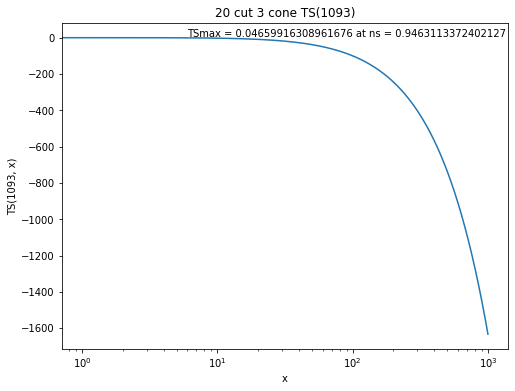

In [9]:
for psrno in range(p):
    #psrno = np.random.randint(0, p)
    pfn = f"Prob20cut3cone-TS({psrno}).jpg"
    #/media/darkwake/VIB2/Project-IceCube/task4/outputs/plots/20cut/3cone/20cut3cone-TS(12).jpg
    fn = f"20cut3cone-TS({psrno}).jpg"
    if not(pfn in os.listdir("outputs/plots/20cut/3cone/")):
        if not(pfn in os.listdir("outputs/plots/20cut/3cone/problematic")):
            singpsr(psrno,  cut = 20, cone = 3)
    
    clear_output(wait=True)

for i in range(p):
    singpsr(i, 20, 6)

psrno = 0
cut = 10
cone = 3
aang = angfinder(psrno)
Ns = nsang(aang)
S = S_ij(psrno)
B = bg(psrno)
TS(psrno, 0)
maxns = TSmax(psrno)
tms = TS(psrno, maxns)
n = np.array(range(0, 1000))
ts = [TS(psrno, x) for x in range(1000)]
plt.figure(figsize=(8,6))
plt.xscale('log')
plt.plot(n, ts)
plt.xlabel('x')
plt.ylabel(f'TS({psrno}, x)')
plt.title(f"{cut} cut {cone} cone TS({psrno})")
plt.text(6, 3, s = f"TSmax = {tms} at ns = {maxns}")
plt.savefig(f"outputs/plots/{cut}cut/{cone}cone/"+f"{cut}cut{cone}cone-TS({psrno}).jpg")
plt.show()